<div>
<img align="left" src="data_sig_logo.jpg" width="450"/>
</div>

### https://datasig.ac.uk/examples

# Controlled Neural Differential Equations - Time Series Classification
This notebook is based on the examples from the `torchcde` package by Kidger and Morrill which can be found at
[https://github.com/patrick-kidger/torchcde](https://github.com/patrick-kidger/torchcde).
Further information about the techniques described in this notebook can be found

> Kidger, P., Morrill, J., Foster, J. and Lyons, T., 2020.
 Neural controlled differential equations for irregular time series.
 arXiv preprint arXiv:[2005.08926](https://arxiv.org/abs/2005.08926).

> Morrill, J., Kidger, P., Yang, L. and Lyons, T., 2021.
 Neural Controlled Differential Equations for Online Prediction Tasks.
 arXiv preprint arXiv:[2106.11028](https://arxiv.org/abs/2106.11028).

> Kidger, P., Foster, J., Li, X., Oberhauser, H. and Lyons, T., 2021.
 Neural sdes as infinite-dimensional gans.
 arXiv preprint arXiv:[2102.03657](https://arxiv.org/abs/2102.03657).

In this notebook we explore the classification of time series data using controlled neural differential equations.

## Set up the notebook

### Install dependencies
This notebook requires PyTorch and the torchcde package.
The dependencies are listed in the `requirements.txt` file.
They can be installed using the following command.

In [7]:
# import sys
# !{sys.executable} -m pip uninstall -y enum34
# !{sys.executable} -m pip install -r requirements.txt

## Import the necessary packages

In [8]:
import math
import numpy as np
import torch
import torchcde
import matplotlib.pyplot as plt

Also set some parameters that can be changed when experimenting with the method.

In [10]:
HIDDEN_LAYER_WIDTH = 64  # This is the width of the hidden layer of the neural network
NUM_EPOCHS = 10  # This is the number of training iterations we will use later
BATCH_SIZE = 32  # Size of batch used in the training process

## Set up the helper classes
A controlled differential equation (CDE) model looks like

$$z_t = z_0 + \int_0^t f_\theta(z_s) dX_s$$

where $X$ is your data and $f_\theta$ is a neural network.
So the first thing we need to do is define such an $f_\theta$.
That's what this `CDEFunc` class does.
Here we've built a small single-hidden-layer neural network, whose hidden layer is of width `HIDDEN_LAYER_WIDTH`
set above.

In [11]:
class CDEFunc(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels):
        ######################
        # input_channels is the number of input channels in the data X. (Determined by the data.)
        # hidden_channels is the number of channels for z_t. (Determined by you!)
        ######################
        super(CDEFunc, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        self.linear1 = torch.nn.Linear(hidden_channels, HIDDEN_LAYER_WIDTH)
        self.linear2 = torch.nn.Linear(
            HIDDEN_LAYER_WIDTH, input_channels * hidden_channels
        )

    ######################
    # For most purposes the t argument can probably be ignored; unless you want your CDE to behave differently at
    # different times, which would be unusual. But it's there if you need it!
    ######################
    def forward(self, t, z):
        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = z.relu()
        z = self.linear2(z)
        ######################
        # Easy-to-forget gotcha: Best results tend to be obtained by adding a final tanh nonlinearity.
        ######################
        z = z.tanh()
        ######################
        # Ignoring the batch dimension, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(z.size(0), self.hidden_channels, self.input_channels)
        return z

Next, we need to package CDEFunc up into a model that computes the integral.

In [18]:
class NeuralCDE(torch.nn.Module):
    def __init__(
        self, input_channels, hidden_channels, output_channels, interpolation="cubic"
    ):
        super(NeuralCDE, self).__init__()

        self.func = CDEFunc(input_channels, hidden_channels)
        self.initial = torch.nn.Linear(input_channels, hidden_channels)
        self.readout = torch.nn.Linear(hidden_channels, output_channels)
        self.interpolation = interpolation

    def forward(self, coeffs):
        if self.interpolation == "cubic":
            X = torchcde.CubicSpline(coeffs)
        elif self.interpolation == "linear":
            X = torchcde.LinearInterpolation(coeffs)
        else:
            raise ValueError(
                "Only 'linear' and 'cubic' interpolation methods are implemented."
            )

        ######################
        # Easy to forget gotcha: Initial hidden state should be a function of the first observation.
        ######################
        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)

        ######################
        # Actually solve the CDE.
        ######################
        z_T = torchcde.cdeint(X=X, z0=z0, func=self.func, t=X.interval)

        ######################
        # Both the initial value and the terminal value are returned from cdeint; extract just the terminal value,
        # and then apply a linear map.
        ######################
        z_T = z_T[:, 1]
        pred_y = self.readout(z_T)
        return pred_y

Now we need some data.
Here we have a simple example which generates some spirals, some going clockwise, some going anticlockwise.

In [19]:
def get_data(num_timepoints=100):
    """
    Generate time series data with `num_timepoints` data points
    """
    t = torch.linspace(0.0, 4 * math.pi, num_timepoints)

    start = torch.rand(HIDDEN_LAYER_WIDTH) * 2 * math.pi
    x_pos = torch.cos(start.unsqueeze(1) + t.unsqueeze(0)) / (1 + 0.5 * t)
    x_pos[: HIDDEN_LAYER_WIDTH // 2] *= -1
    y_pos = torch.sin(start.unsqueeze(1) + t.unsqueeze(0)) / (1 + 0.5 * t)
    x_pos += 0.01 * torch.randn_like(x_pos)
    y_pos += 0.01 * torch.randn_like(y_pos)
    ######################
    # Easy to forget gotcha: time should be included as a channel; Neural CDEs need to be explicitly told the
    # rate at which time passes. Here, we have a regularly sampled dataset, so appending time is pretty simple.
    ######################
    X = torch.stack([t.unsqueeze(0).repeat(HIDDEN_LAYER_WIDTH, 1), x_pos, y_pos], dim=2)
    y = torch.zeros(HIDDEN_LAYER_WIDTH)
    y[: HIDDEN_LAYER_WIDTH // 2] = 1

    perm = torch.randperm(HIDDEN_LAYER_WIDTH)
    X = X[perm]
    y = y[perm]

    ######################
    # X is a tensor of observations, of shape (batch=128, sequence=100, channels=3)
    # y is a tensor of labels, of shape (batch=128,), either 0 or 1 corresponding to anticlockwise or clockwise respectively.
    ######################
    return X, y

## Getting the training data
Now we use the `get_data` function we just defined to create a set of data to train the model.

In [20]:
train_X, train_y = get_data()

To illustrate the kind of data, we plot examples of the anticlockwise and clockwise spirals from this training set.
The radius of the spiral decreases as time progresses.

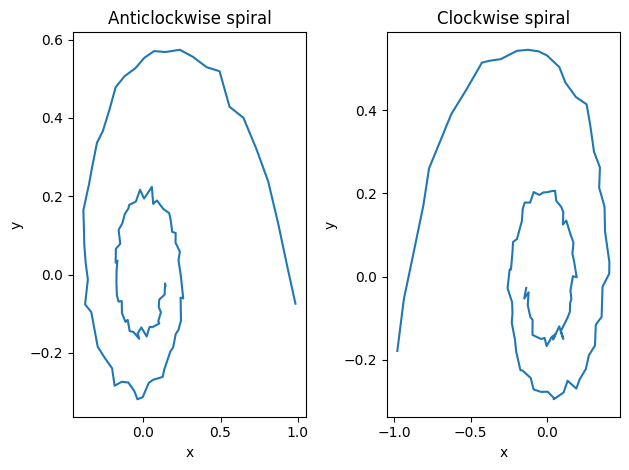

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True)
(idx,) = np.where(train_y == 0)
ax1.plot(train_X[idx[0], :, 1], train_X[idx[0], :, 2])
ax1.set_title("Anticlockwise spiral")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

(idx,) = np.where(train_y == 1)
ax2.plot(train_X[idx[0], :, 1], train_X[idx[0], :, 2])
ax2.set_title("Clockwise spiral")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
plt.show()

input_channels=3 because we have both the horizontal and vertical position of a point in the spiral, and time.
hidden_channels=8 is the number of hidden channels for the evolving $z_t$, which we get to choose.
output_channels=1 because we're doing binary classification.

In [22]:
model = NeuralCDE(input_channels=3, hidden_channels=8, output_channels=1)
optimizer = torch.optim.Adam(model.parameters())

Now we turn our dataset into a continuous path. We do this here via natural cubic spline interpolation.
The resulting `train_coeffs` is a tensor describing the path.
For most problems, it's probably easiest to save this tensor and treat it as the dataset.

In [23]:
train_coeffs = torchcde.natural_cubic_coeffs(train_X)
train_dataset = torch.utils.data.TensorDataset(train_coeffs, train_y)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

for epoch in range(NUM_EPOCHS):
    for batch in train_dataloader:
        batch_coeffs, batch_y = batch
        pred_y = model(batch_coeffs).squeeze(-1)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(pred_y, batch_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print("Epoch: {:2d}   Training loss: {}".format(epoch, loss.item()))

Epoch:  0   Training loss: 1.251300573348999
Epoch:  1   Training loss: 0.7866948246955872
Epoch:  2   Training loss: 0.6906827688217163
Epoch:  3   Training loss: 0.671246349811554
Epoch:  4   Training loss: 0.615376353263855
Epoch:  5   Training loss: 0.5963273644447327
Epoch:  6   Training loss: 0.5998020172119141
Epoch:  7   Training loss: 0.5952240228652954
Epoch:  8   Training loss: 0.5835024118423462
Epoch:  9   Training loss: 0.5762784481048584


## Validating the model
Now we need to validate the model that we have trained.
First we create some new data using the same function as before.
Then we proceed as before, fitting cubic splines and evaluating the newly trained model on these data.

In [24]:
test_X, test_y = get_data()

test_coeffs = torchcde.natural_cubic_coeffs(test_X)
pred_y = model(test_coeffs).squeeze(-1)
binary_prediction = (torch.sigmoid(pred_y) > 0.5).to(test_y.dtype)
prediction_matches = (binary_prediction == test_y).to(test_y.dtype)
proportion_correct = prediction_matches.sum() / test_y.size(0)
print("Test Accuracy: {}".format(proportion_correct))

Test Accuracy: 0.65625
